#Check For Duplicates in Dataset

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, json
from scipy.misc import imresize
from IPython.html.widgets import interact
from IPython.display import clear_output
import cPickle as pickle
from networkx import Graph, connected_components

:0: FutureWarning: IPython widgets are experimental and may change in the future.


###Get Image Paths

In [10]:
images = []

for path, dirs, files in os.walk('.'):
    for file in files:
        if '.jpg' in file.lower() and 'images' in path:
            image = os.path.join(path, file)
            images.append(image)            

images = sorted(images)

print len(images)

81235


In [5]:
with open('images.json', 'wb') as file: json.dump(images, file)

###Form Data Matrix

In [6]:
X = zeros((len(images), 256, 256, 3), dtype='uint8')

for i, x in enumerate(images):
    
    try:
        X[i] = imresize(imread(x), (256,256))
    except:
        print x
    
    if i%100 is 0:
        clear_output()
        display(i)

81800

In [ ]:
with open('X.npy', 'wb') as file: save(file, X)

###Calculate Distance Matrix (not really)

In [ ]:
with open('X.npy', 'rb') as file: X = load(file)
X = X.reshape(len(X),-1).astype(float32)
G = X.dot(X.T)

In [ ]:
with open('G.npy', 'wb') as file: save(file, G)

In [4]:
with open('X.npy', 'rb') as file: X = load(file)
s = [sum(x.astype(float32)**2) for x in X]

In [8]:
s=array([s]).T

In [9]:
with open('s.npy', 'wb') as file: save(file, s)
del X

In [3]:
with open('s.npy', 'rb') as file: s = load(file)
with open('G.npy', 'rb') as file: G = load(file)
D = sqrt(s-2*G+s.T).astype(float16)
with open('D.npy', 'wb') as file: save(file, D)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [4]:
sum(isnan(D))

38283

In [ ]:
with open('X.npy', 'rb') as file: X = load(file)
X = X.reshape(len(X),-1).astype(float32)
s = sum(X**2, axis=1, keepdims=True)
D = s-2*X.dot(X.T)+s.T

###Verify Distance Matrix

In [3]:
with open('X.npy', 'rb') as file: X = load(file)
with open('D.npy', 'rb') as file: D = load(file)

In [8]:
i, j = randint(len(X), size=2)
xi = X[i].astype(float32)
xj = X[j].astype(float32)
print norm(xi-xj)
print D[i,j]

34317.8
34304.0


###Find Similar Pairs

In [3]:
with open('D.npy', 'rb') as file: D = load(file)
with open('s.npy', 'rb') as file: s = load(file)
corrupted_images = s[:,0]==0
D[corrupted_images] = inf
D[:,corrupted_images] = inf
n = len(D)
d = D[tril(ones((n,n), dtype=bool), k=-1)]
del D
k = 10**4
i = argpartition(d, k)[:k].copy()
i = i[argsort(d[i])]
d = d[i].copy()
IJ = tril_indices(n, k=-1)
IJ = zip(IJ[0][i], IJ[1][i])
with open('d.npy', 'wb') as file: save(file, d)
with open('IJ.npy', 'wb') as file: save(file, IJ)

###Show Pairs

In [3]:
with open('X.npy', 'rb') as file: X = load(file)
with open('d.npy', 'rb') as file: d = load(file)
with open('IJ.npy', 'rb') as file: IJ = load(file)
with open('images.json', 'rb') as file: images = json.load(file)

6252.0

u'./dermnet/images/seborrheic-keratoses-ruff-200.jpg'

u'./dermnet/images/melanocytic-nevi-50.jpg'

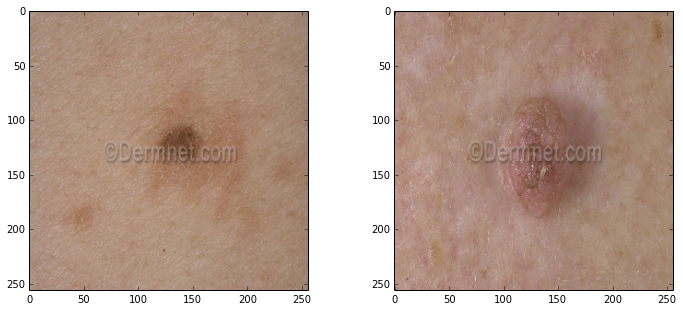

In [4]:
k = 10**3

fig = figure(figsize=(12,5))
subplot(1,2,1)
plt1 = imshow(X[0])
subplot(1,2,2)
plt2 = imshow(X[0])

@interact(pair=(0, k-1))
def show_pair(pair):
    i, j = IJ[pair]
    plt1.set_array(X[i])
    plt2.set_array(X[j])
    display(d[pair])
    display(images[i])
    display(images[j])
    display(fig)

In [ ]:
with open('D.npy', 'rb') as file: D = load(file)
n = len(D)
d = D[tril(ones((n,n), dtype=bool), k=-1)]
d = d[d<inf]
del D

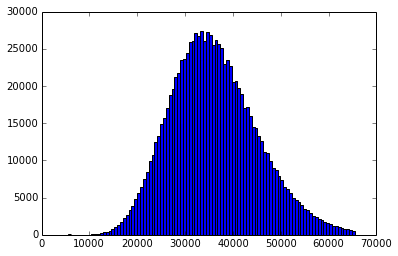

In [8]:
hist(random.choice(d, size=10**6), bins=100);

###Remove Duplicate and Corrupted Images

In [8]:
with open('s.npy', 'rb') as file: s = load(file)
with open('d.npy', 'rb') as file: d = load(file)
with open('IJ.npy', 'rb') as file: IJ = load(file)
with open('images.json', 'rb') as file: images = json.load(file)

corrupted = s[:,0]==0

G = Graph()
G.add_edges_from(IJ[d<4000])
C = [c for c in connected_components(G)]

duplicate = sum(C)
for c in C: duplicate.remove(random.choice(c))

corrupted_images = array(images)[corrupted]
duplicate_images = array(images)[duplicate]

bad_images = concatenate([corrupted_images, duplicate_images])

msg = 'found {} duplicate and {} corrupted images'
print msg.format(len(duplicate_images), len(corrupted_images))

found 559 duplicate and 54 corrupted images


In [9]:
for image in bad_images: os.remove(image)